In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="7"

Sat Jan 27 01:05:19 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   51C    P0   153W / 300W |   8299MiB / 80994MiB |     22%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.net_64_encoder import Encoder
from model.prior.dalle_rand_prior import Prior
from model.latent.dalle_lse_latent import Latent
from model.quantizer.dalle_nearest_quantizer import Quantizer
from model.decoder.net_64_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 64
hp.n_resblocks = 6
hp.z_dim = 64
hp.n_prior_embeddings = 512
hp.init_log_sigma = 0
hp.const_sigma = False
hp.quantize = True
hp.prior_mu = 0.999
hp.z_activation = F.tanh
hp.M = hp.n_prior_embeddings

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Quantizer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 1.2191162109375
encoder.encoder 1.2191162109375
prior 0.126953125
latent 3.814697265625e-06
quantizer 0.0
decoder 1.0611686706542969
decoder.decoder 1.0611686706542969
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train_dalle/train01.19-7_tanh_0.999_lr1e-6_hardquantize/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 9473, model_list, optimizer_list)

total 0


### Dataset

In [7]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.img_size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
print('done')

done


In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [10]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

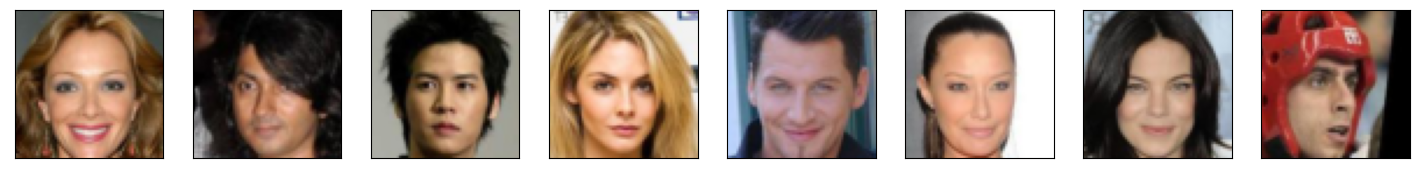

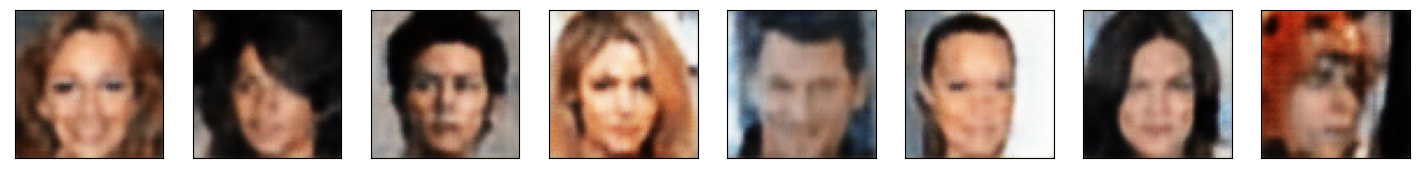

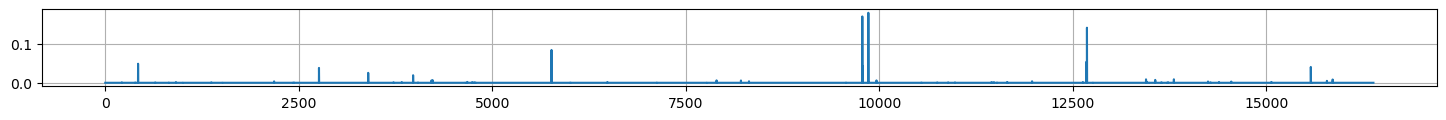

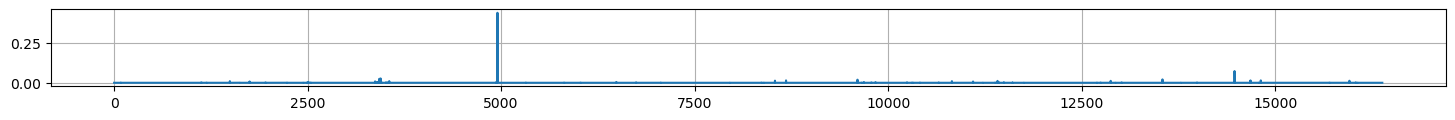

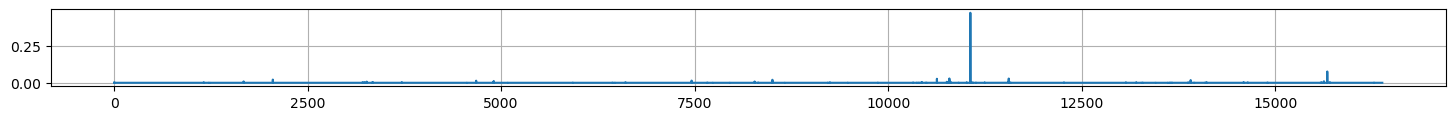

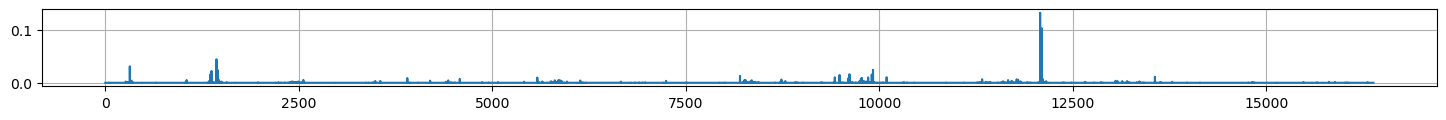

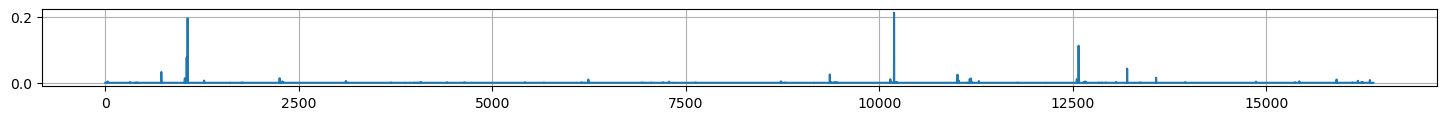

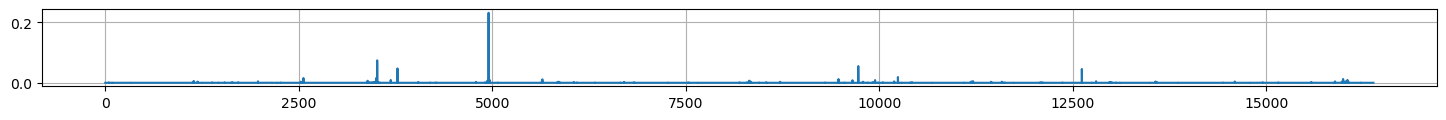

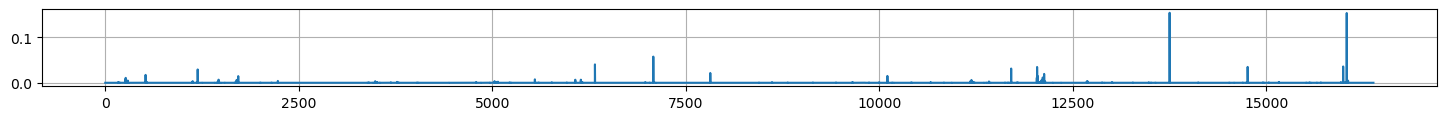

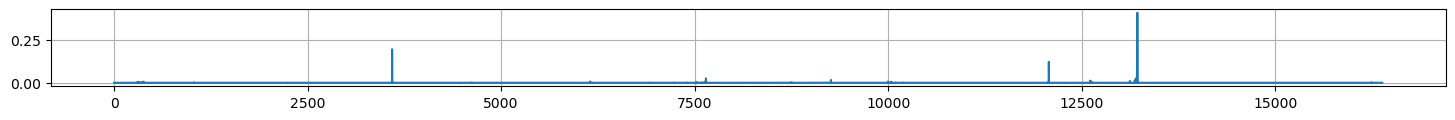

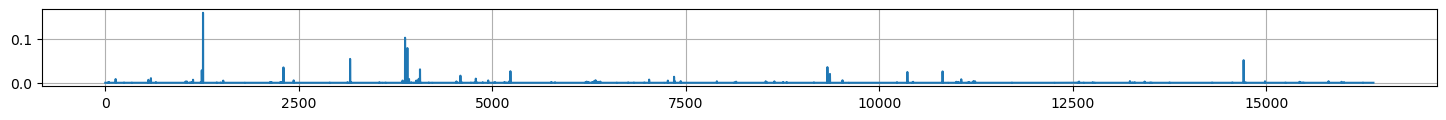

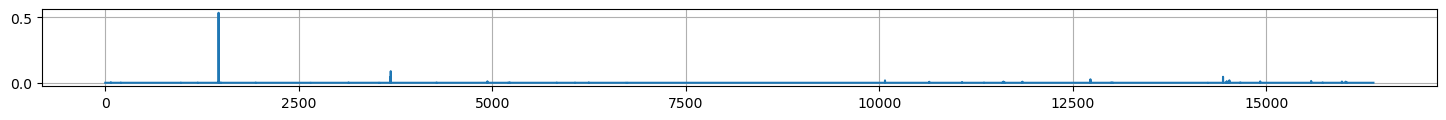

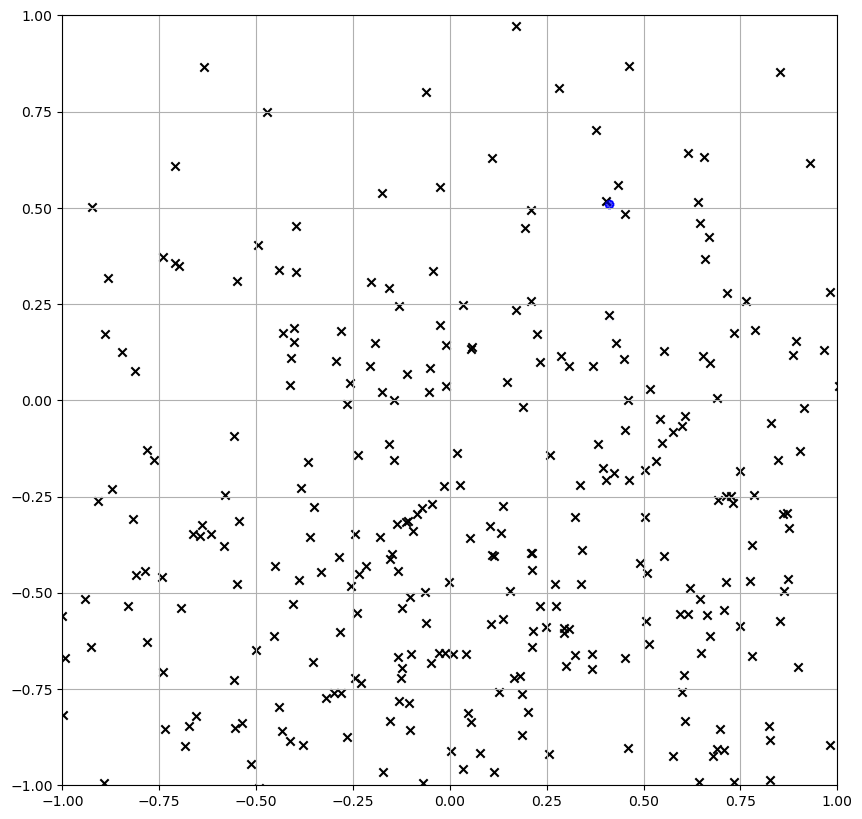

2001
lse_loss -11.903857231140137
commit_loss 0.30530017614364624
recon_loss 0.00433820765465498
2002
lse_loss -11.839816093444824
commit_loss 0.3039548099040985
recon_loss 0.004285992123186588
2003
lse_loss -12.186274528503418
commit_loss 0.301977276802063
recon_loss 0.004936962854117155
2004
lse_loss -12.107115745544434
commit_loss 0.2999345362186432
recon_loss 0.00468523520976305
2005
lse_loss -12.489829063415527
commit_loss 0.2990756928920746
recon_loss 0.004998566582798958
2006
lse_loss -11.99834156036377
commit_loss 0.3043869733810425
recon_loss 0.004342086147516966
2007
lse_loss -11.968552589416504
commit_loss 0.30349329113960266
recon_loss 0.004927784204483032
2008
lse_loss -12.200348854064941
commit_loss 0.30235427618026733
recon_loss 0.004469593986868858
2009
lse_loss -11.99549388885498
commit_loss 0.30515557527542114
recon_loss 0.0046565779484808445
2010
lse_loss -11.955716133117676
commit_loss 0.30457258224487305
recon_loss 0.0044561391696333885
2011
lse_loss -12.0307035446

lse_loss -12.292448997497559
commit_loss 0.3018665909767151
recon_loss 0.004532316699624062
2088
lse_loss -12.141810417175293
commit_loss 0.30432289838790894
recon_loss 0.004375840537250042
2089
lse_loss -11.870203971862793
commit_loss 0.30466002225875854
recon_loss 0.004518662579357624
2090
lse_loss -12.308833122253418
commit_loss 0.30048471689224243
recon_loss 0.0044519780203700066
2091
lse_loss -12.004733085632324
commit_loss 0.30444300174713135
recon_loss 0.003962326794862747
2092
lse_loss -12.341643333435059
commit_loss 0.30072909593582153
recon_loss 0.005252916365861893
2093
lse_loss -11.87454891204834
commit_loss 0.30428647994995117
recon_loss 0.004983358085155487
2094
lse_loss -12.122511863708496
commit_loss 0.3026352524757385
recon_loss 0.004570494405925274
2095
lse_loss -12.302437782287598
commit_loss 0.2996867299079895
recon_loss 0.005388341844081879
2096
lse_loss -12.24865436553955
commit_loss 0.30210262537002563
recon_loss 0.004240051377564669
2097
lse_loss -12.17088222503

lse_loss -12.20197582244873
commit_loss 0.30306440591812134
recon_loss 0.004407442640513182
2173
lse_loss -12.326310157775879
commit_loss 0.3048928678035736
recon_loss 0.004695625975728035
2174
lse_loss -12.270037651062012
commit_loss 0.30680587887763977
recon_loss 0.004880962893366814
2175
lse_loss -12.381897926330566
commit_loss 0.3032081425189972
recon_loss 0.004012826830148697
2176
lse_loss -12.334979057312012
commit_loss 0.30348023772239685
recon_loss 0.004159597679972649
2177
lse_loss -12.288290977478027
commit_loss 0.3046530485153198
recon_loss 0.004727703984826803
2178
lse_loss -12.295790672302246
commit_loss 0.3043981194496155
recon_loss 0.004173756577074528
2179
lse_loss -12.226126670837402
commit_loss 0.30325689911842346
recon_loss 0.004210933111608028
2180
lse_loss -12.097926139831543
commit_loss 0.305147647857666
recon_loss 0.00465564988553524
2181
lse_loss -12.118582725524902
commit_loss 0.3015754222869873
recon_loss 0.004731801338493824
2182
lse_loss -12.23740291595459
c

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, latent_temp=1, quant_temp=0)

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key] * 1e-6
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'commit_loss' in key:
                    loss = loss + data[key] * 0
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
            
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            
            log_sigma = model.latent.log_sigma.item()
            writer.add_scalar('log_sigma', log_sigma, step)
            
            usage = ((data['belong'].sum(dim=0) > 0).sum() / hp.M).item()
            writer.add_scalar('usage', usage, step)            

            import matplotlib.pyplot as plt
            display.clear_output()
            
            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
                        
            grad = torch.softmax(data['matrix'], dim=0)
            grad = grad.data.cpu().numpy()

            import matplotlib.pyplot as plt

            for i in np.random.randint(0, grad.shape[1], size=[10]):
                plt.figure(figsize=[18, 1])
                plt.plot(grad[:, i])
                plt.grid()
                plt.show()
            
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            e = model.prior.prior.data.cpu().numpy()
            pca.fit(e)
            e_pca = pca.transform(e)
            z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
            plt.figure(figsize=[10, 10])
            plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
            plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
            plt.xlim([-1, 1])
            plt.ylim([-1, 1])
            plt.grid()
            plt.show() 
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')

In [ ]:
import matplotlib.pyplot as plt
display.clear_output()

x = data['x']
y = data['y']

plot(x)
plot(y)

grad = torch.softmax(data['matrix'], dim=0)
grad = grad.data.cpu().numpy()

import matplotlib.pyplot as plt

for i in np.random.randint(0, grad.shape[1], size=[10]):
    plt.figure(figsize=[18, 1])
    plt.plot(grad[:, i])
    plt.grid()
    plt.show()

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
e = model.prior.prior.data.cpu().numpy()
pca.fit(e)
e_pca = pca.transform(e)
z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
plt.figure(figsize=[10, 10])
plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
plt.grid()
plt.show() 